HOMEWORK 4: CROSS VALIDATION

# Questions

In this homework, you will do a cross validation for
BioModels model 45. Although the model has a large number of parameters, we will only consider ``beta``.


1. (20 pts) **Data Generation**. Create synthetic data for the floating species using the values of the parameter in the published model:
   1. (10 pts) Create 3 sets of synthetic data for standard deviations of 0.1, 0.2, and 0.5.
   1. (10 pts) Plot the three datatsets. What characteristics of the data confirm that these synthetic data
   are consistent with your expectations.
   
1. (60 pts) **Experiment Implementation**. Implement codes that do cross validation. It should input the number of folds (possibly
with other arguments); a DataFrame with rows for the model and for beta and columns
for the mean, standard deviation, lower end of the 90 percent confidence interval,
and upper end of this confidence interval.
You should have codes for:

   1. (30 pts) ``crossValidate`` - overall workflow for doing cross validation
      * Inputs: model (str), observedData (matrix), parameterNames (list-str)
      * Outputs: DataFrame as described above
   1. (15 pts) ``calcRsq``
      * Inputs: predicted values (matrix), observed values (marix)
      * Ouputs: float
   1. (15 pts) ``reportResults``
      * Inputs: $R^2$ values (list-float), parameter estimates (list-dict)
      * Outputs: DataFrame with mean, stadard deviation, and 90% confidence interval for model and parameters
   
   Feel free to make use of the codes from class and/or the codes in the "Helpers" section.
   As always, you should abide by the rules for writing software.
   
1. (20 pts) **Experiment Execution and Analysis**. Do a 3, 5, and 10 fold cross validation using alternating folds for the 3 datasets. That is, fold 1 has the points 1, 11, 21, ..;
fold 2 has the points 2, 12, 22, ...; and so on. 
   1. (5 pts) Construct heatmaps for the standard deviation of model $R^2$ and the standard deviation of ``beta`` where the horizontal axis is standard deviation of noise in observed data and the vertical axis
   is the number of folds.
   1. (5 pts) For $R^2$, how is variability affected
by the number of folds? How is variability affected by the variability of the training data?
   1. (5 pts) For ``beta``, how is variability affected
by the number of folds? How is variability affected by the variability of the training data?
   1. (5 pts) Based on your answers to the last two questions, how many folds would you use to evaluate model quality and assess the quality of parameter estimates? What's another reason for your choice of the number of folds?
   
1. (10 pt) **Extra credit.** How would you frame the analysis in (3) using the language of design of experiments.

**Please do your homework in a copy of this notebook, maintaining the sections.**

# Programming Preliminaries
This section provides the setup to run your python codes.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te
try:
    import SBstoat
except:
    !pip install -q SBstoat
    import SBstoat

## Constants

In [2]:
ENDTIME = 60
NUMPOINT = 1200
STDS = [0.1, 0.2, 0.5]
NUMFOLDS = [3, 5, 10]
# Column names
C_TIME = "time"
#

## BioModels 45

In [3]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index(C_TIME)
    return df

# Tests
if False:
    arr = np.array(range(10))
    arr = np.reshape(arr, (2, 5))
    df = arrToDF(arr)
    assert(isinstance(df, pd.DataFrame))

In [6]:
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
MODEL_ANT = MODEL_RR.getAntimony()
print(MODEL_ANT)

// Created by libAntimony v2.12.0
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  beta = 1;
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  v2i_

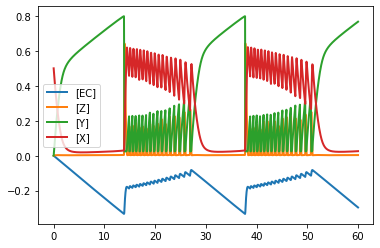

In [7]:
# Values of model parameters in the model
MODEL_RR.reset()
MODEL_ARR = MODEL_RR.simulate(0, 60, 1200)
MODEL_RR.plot(MODEL_ARR)
MODEL_DF = arrToDF(MODEL_ARR)

## Helper Functions

In [8]:
def foldGenerator(numPoint, numFold):
    """
    Generates pairs of trainining and test indices.
    
    Parameters:
    ----------
    numPoint: int
        number of time points
    numFold: int
        number of pairs of testIndices and trainIndices
    
    Returns:
    --------
    list of pairs of train indices, test indices
    """
    indices = range(numPoint)
    for remainder in range(numFold):
        testIndices = []
        for idx in indices:
            if idx % numFold == remainder:
                testIndices.append(idx)
        trainIndices = list(set(indices).difference(testIndices))
        yield trainIndices, testIndices
        
# Tests
numpoint = 6
numfold = 3
generator = foldGenerator(numpoint, numfold)
folds = list(generator)
assert(len(folds) == numfold)
for fold in folds:
    composite = list(fold[0])
    composite.extend(fold[1])
    assert(len(composite) == numpoint)
print("OK!")

OK!


In [9]:
def findCloseMatchingValues(longArr, shortArr):
    """
    Finds the indices in longArr that are closest to the values in shortArr.

    Parameters
    ----------
    longArr: np.array
    shortArr: np.arry

    Returns
    -------
    array-int
    """
    indices = []
    for val in shortArr:
        distances = (longArr - val)**2
        minDistance = np.min(distances)
        distancesLst = list(distances)
        idx = distancesLst.index(minDistance)
        indices.append(idx)
    return np.array(indices)

# TESTS
longArr = np.array(range(10))
shortArr = np.array([2.1, 2.9, 4.3])
indexArr = findCloseMatchingValues(longArr, shortArr)
expectedArr = [2, 3, 4]
assert(all([v1 == v2 for v1, v2 in zip(indexArr, expectedArr)]))
print("OK!")

OK!


In [10]:
def makeSyntheticData(df, std):
    """
    Creates synthetic data by adding a normally distributed random variable with mean zero and the specified
    standard deviation.
    
    Parameters
    ----------
    df: DataFrame
    std: float
    
    Returns
    -------
    DataFrame with same index and column names as df
    """
    timeseries = SBstoat.NamedTimeseries(dataframe=df)
    synthesizer = SBstoat.ObservationSynthesizerRandomErrors(fittedTS=timeseries, std=std)
    syntheticTS = synthesizer.calculate()
    df =  syntheticTS.to_dataframe()
    return df

#TESTS
observedDF = makeSyntheticData(MODEL_DF, 0)
assert(observedDF.equals(MODEL_DF))
print("OK!")

OK!


In [11]:
def fitModel(model, observedDF, parameterNames, testIdxs):
    """
    Fits the model parameters to the observed data.
    
    Parameters
    ----------
    model: str
        Antimony model or roadrunner
    observedDF: DataFrame
        Index: time
        Columns: floating species
    parameterNames: list-str
    testIdxs: list-int
        Indices in data that should be ignored in fitting since
        they will be used to evaluate test data
    
    Returns
    -------
    parameterDct
        key: parameterName
        value: parameterEstimate
    DataFrame - fitted values
        key: time
        columns: floating species     
    """
    indexArr = np.array(observedDF.index)
    endTime = max(observedDF.index)
    testIndices = indexArr[testIdxs]  # Elements in index that are test data
    newObservedDF = observedDF.copy()
    newObservedDF.loc[testIndices, :] = np.nan
    newObservedDF.index.name = C_TIME
    observedTS = SBstoat.NamedTimeseries(dataframe=newObservedDF)
    fitter = SBstoat.ModelFitter(model, observedTS,
                          parameterNames,
                          endTime=endTime,
                          numPoint=len(observedDF))
    fitter.fitModel()
    parameterDct = dict(fitter.params.valuesdict())
    #
    return parameterDct, fitter.fittedTS.to_dataframe()

# Tests
observedDF = makeSyntheticData(MODEL_DF, 0)
observedDF = observedDF[observedDF.index < 5]
parameterDct, fittedDF = fitModel(MODEL_ANT, observedDF, ["beta"], [10, 20])
assert(len(parameterDct) == 1)
assert(np.abs(parameterDct["beta"] - 1) < 0.001)
assert(len(observedDF) == len(fittedDF))
print("OK!")

OK!


# Question 1: Data Generation

# Question 2: Experiment Implementation

# Question 3: Experiment Execution and Analysis